# Your First Neural Network

## Introduction

In this notebook, we build a **neural network from scratch** — a 2-layer network with one hidden layer. We'll use the same classification dataset from L3 (logistic regression), so we can directly compare the performance!

### What We'll Build

| Component | Logistic Regression (L3) | Neural Network (L4) |
|-----------|-------------------------|---------------------|
| Architecture | 4 inputs → 1 output | 4 inputs → 3 hidden → 1 output |
| Parameters | 4 weights | 4×3 + 3×1 = 15 weights |
| Decision boundary | Linear (plane) | Non-linear (curved) |

### What You'll Learn

- **Forward propagation** through multiple layers
- **Backpropagation** — computing gradients using the chain rule
- **Matrix dimension tracking** at every step
- Why hidden layers make networks more powerful

## 1. Setup and Data Loading

We use the **same dataset** from L3 (logistic regression). This way, we can directly compare:
- L3 (single neuron) accuracy vs L4 (neural network) accuracy

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go

# Set style for better visualizations
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = [10, 6]
plt.rcParams['font.size'] = 12

In [6]:
# Load the same dataset from L3
data = pd.read_csv("data\classification_data.csv")

print(f"Dataset shape: {data.shape}")
print(f"\nFirst 5 rows:")
data.head()

Dataset shape: (200, 4)

First 5 rows:


<>:2: SyntaxWarning: invalid escape sequence '\c'
<>:2: SyntaxWarning: invalid escape sequence '\c'
C:\Users\leoje\AppData\Local\Temp\ipykernel_38860\3257685220.py:2: SyntaxWarning: invalid escape sequence '\c'
  data = pd.read_csv("data\classification_data.csv")


,x1,x2,x3,y
0,0.496714,-0.138264,0.647689,1.0
1,1.523030,-0.234153,-0.234137,1.0
2,1.579213,0.767435,-0.469474,1.0
3,0.542560,-0.463418,-0.465730,1.0
4,0.241962,-1.913280,-1.724918,1.0


In [7]:
# Extract features and labels
X_raw = data[['x1', 'x2', 'x3']].values
y = data['y'].values.reshape(-1, 1)  # Reshape to column vector for neural network
m = len(y)  # Number of samples

# Add bias column (x0 = 1)
X = np.column_stack([np.ones(m), X_raw])

print(f"X shape: {X.shape}  → (samples, features including bias)")
print(f"y shape: {y.shape}  → (samples, 1)")
print(f"Class distribution: Class 0 = {np.sum(y == 0)}, Class 1 = {np.sum(y == 1)}")

X shape: (200, 4)  → (samples, features including bias)
y shape: (200, 1)  → (samples, 1)
Class distribution: Class 0 = 71, Class 1 = 129


## 2. Network Architecture

Our neural network has:
- **Input layer**: 4 neurons (3 features + 1 bias)
- **Hidden layer**: 3 neurons with sigmoid activation
- **Output layer**: 1 neuron with sigmoid activation

```
Input (4)  →  Hidden (3)  →  Output (1)
   X       →     a¹       →     h
```

### Weight Matrices

- $\mathbf{W}^{[1]}$: shape $(4, 3)$ — connects input to hidden
- $\mathbf{W}^{[2]}$: shape $(3, 1)$ — connects hidden to output

In [8]:
# Network architecture
n_input = 4    # Number of input features (including bias)
n_hidden = 3   # Number of hidden neurons
n_output = 1   # Number of output neurons

print("="*50)
print("NETWORK ARCHITECTURE")
print("="*50)
print(f"Input layer:  {n_input} neurons")
print(f"Hidden layer: {n_hidden} neurons")
print(f"Output layer: {n_output} neuron")
print("="*50)
print(f"\nWeight matrix shapes:")
print(f"W1: ({n_input}, {n_hidden}) = {n_input * n_hidden} parameters")
print(f"W2: ({n_hidden}, {n_output}) = {n_hidden * n_output} parameters")
print(f"Total: {n_input * n_hidden + n_hidden * n_output} parameters")

NETWORK ARCHITECTURE
Input layer:  4 neurons
Hidden layer: 3 neurons
Output layer: 1 neuron

Weight matrix shapes:
W1: (4, 3) = 12 parameters
W2: (3, 1) = 3 parameters
Total: 15 parameters


## 3. Activation Function

We use the **sigmoid** activation function:

$$\sigma(z) = \frac{1}{1 + e^{-z}}$$

And its derivative:

$$\sigma'(z) = \sigma(z) \cdot (1 - \sigma(z))$$

The derivative is crucial for backpropagation!

In [9]:
def sigmoid(z):
    """Sigmoid activation function."""
    return 1 / (1 + np.exp(-z))

def sigmoid_derivative(z):
    """Derivative of sigmoid: sigmoid(z) * (1 - sigmoid(z))."""
    s = sigmoid(z)
    return s * (1 - s)

<>:5: SyntaxWarning: invalid escape sequence '\s'
<>:6: SyntaxWarning: invalid escape sequence '\s'
<>:5: SyntaxWarning: invalid escape sequence '\s'
<>:6: SyntaxWarning: invalid escape sequence '\s'
C:\Users\leoje\AppData\Local\Temp\ipykernel_38860\281409252.py:5: SyntaxWarning: invalid escape sequence '\s'
  ax.plot(z, sigmoid(z), linewidth=3, color='#e74c3c', label='$\sigma(z)$')
C:\Users\leoje\AppData\Local\Temp\ipykernel_38860\281409252.py:6: SyntaxWarning: invalid escape sequence '\s'
  ax.plot(z, sigmoid_derivative(z), linewidth=3, color='#3498db', label="$\sigma'(z)$")


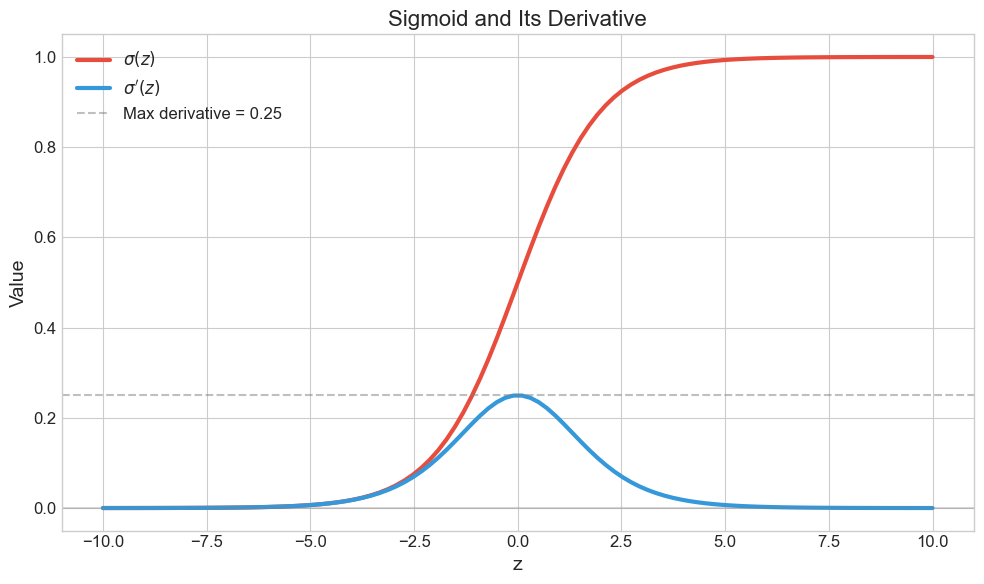

In [10]:
# Visualize sigmoid and its derivative
z = np.linspace(-10, 10, 100)

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(z, sigmoid(z), linewidth=3, color='#e74c3c', label='$\sigma(z)$')
ax.plot(z, sigmoid_derivative(z), linewidth=3, color='#3498db', label="$\sigma'(z)$")
ax.axhline(y=0, color='gray', linestyle='-', alpha=0.3)
ax.axhline(y=0.25, color='gray', linestyle='--', alpha=0.5, label='Max derivative = 0.25')

ax.set_xlabel('z', fontsize=14)
ax.set_ylabel('Value', fontsize=14)
ax.set_title('Sigmoid and Its Derivative', fontsize=16)
ax.legend(fontsize=12)

plt.tight_layout()
plt.show()

## 4. Weight Initialization

We initialize weights with **small random values**.

**Why random?** To break symmetry — if all weights start the same, all neurons learn the same thing.

**Why small?** Large weights → large z → sigmoid saturates → tiny gradients → no learning!

In [11]:
def initialize_weights(n_input, n_hidden, n_output, seed=42):
    """Initialize weights with small random values."""
    np.random.seed(seed)
    
    W1 = np.random.randn(n_input, n_hidden) * 0.01
    W2 = np.random.randn(n_hidden, n_output) * 0.01
    
    return W1, W2

In [12]:
# Initialize weights
W1, W2 = initialize_weights(n_input, n_hidden, n_output)

print("INITIAL WEIGHTS")
print("="*50)
print(f"W1 shape: {W1.shape}")
print(f"W1 values:\n{W1}")
print(f"\nW2 shape: {W2.shape}")
print(f"W2 values:\n{W2}")

INITIAL WEIGHTS
W1 shape: (4, 3)
W1 values:
[[ 0.00496714 -0.00138264  0.00647689]
 [ 0.0152303  -0.00234153 -0.00234137]
 [ 0.01579213  0.00767435 -0.00469474]
 [ 0.0054256  -0.00463418 -0.0046573 ]]

W2 shape: (3, 1)
W2 values:
[[ 0.00241962]
 [-0.0191328 ]
 [-0.01724918]]


## 5. Forward Propagation

Forward propagation computes the output by passing through each layer:

### Layer 1 (Hidden)
$$\mathbf{z}^{[1]} = \mathbf{X} \cdot \mathbf{W}^{[1]}$$
$$\mathbf{a}^{[1]} = \sigma(\mathbf{z}^{[1]})$$

### Layer 2 (Output)
$$\mathbf{z}^{[2]} = \mathbf{a}^{[1]} \cdot \mathbf{W}^{[2]}$$
$$h = \sigma(\mathbf{z}^{[2]})$$

In [13]:
def forward(X, W1, W2):
    """
    Forward propagation through the neural network.
    
    Returns all intermediate values (needed for backprop).
    """
    # Layer 1: Input → Hidden
    z1 = np.dot(X, W1)      # Linear transformation
    a1 = sigmoid(z1)         # Activation
    
    # Layer 2: Hidden → Output
    z2 = np.dot(a1, W2)     # Linear transformation
    h = sigmoid(z2)          # Activation (output)
    
    # Cache all values for backprop
    cache = {'z1': z1, 'a1': a1, 'z2': z2, 'h': h}
    
    return h, cache

In [14]:
# Test forward propagation with dimension checks
h, cache = forward(X, W1, W2)

print("FORWARD PROPAGATION - DIMENSION CHECK")
print("="*60)
print(f"\nLayer 1 (Input → Hidden):")
print(f"  X shape:   {X.shape}")
print(f"  W1 shape:  {W1.shape}")
print(f"  z1 = X · W1")
print(f"  z1 shape:  {cache['z1'].shape}  ← ({X.shape[0]}, {X.shape[1]}) · ({W1.shape[0]}, {W1.shape[1]}) = ({cache['z1'].shape[0]}, {cache['z1'].shape[1]})")
print(f"  a1 = σ(z1)")
print(f"  a1 shape:  {cache['a1'].shape}")

print(f"\nLayer 2 (Hidden → Output):")
print(f"  a1 shape:  {cache['a1'].shape}")
print(f"  W2 shape:  {W2.shape}")
print(f"  z2 = a1 · W2")
print(f"  z2 shape:  {cache['z2'].shape}  ← ({cache['a1'].shape[0]}, {cache['a1'].shape[1]}) · ({W2.shape[0]}, {W2.shape[1]}) = ({cache['z2'].shape[0]}, {cache['z2'].shape[1]})")
print(f"  h = σ(z2)")
print(f"  h shape:   {h.shape}")

print(f"\n" + "="*60)
print(f"✓ Output shape {h.shape} matches y shape {y.shape}!")

FORWARD PROPAGATION - DIMENSION CHECK

Layer 1 (Input → Hidden):
  X shape:   (200, 4)
  W1 shape:  (4, 3)
  z1 = X · W1
  z1 shape:  (200, 3)  ← (200, 4) · (4, 3) = (200, 3)
  a1 = σ(z1)
  a1 shape:  (200, 3)

Layer 2 (Hidden → Output):
  a1 shape:  (200, 3)
  W2 shape:  (3, 1)
  z2 = a1 · W2
  z2 shape:  (200, 1)  ← (200, 3) · (3, 1) = (200, 1)
  h = σ(z2)
  h shape:   (200, 1)

✓ Output shape (200, 1) matches y shape (200, 1)!


## 6. Cost Function

We use **binary cross-entropy** (same as logistic regression):

$$J = -\frac{1}{m} \sum_{i=1}^{m} \left[ y^{(i)} \log(h^{(i)}) + (1-y^{(i)}) \log(1-h^{(i)}) \right]$$

In [15]:
def compute_cost(h, y):
    """Binary cross-entropy cost function."""
    m = len(y)
    # Clip to avoid log(0)
    epsilon = 1e-15
    h = np.clip(h, epsilon, 1 - epsilon)
    
    cost = -np.mean(y * np.log(h) + (1 - y) * np.log(1 - h))
    return cost

In [16]:
# Compute initial cost
initial_cost = compute_cost(h, y)
print(f"Initial cost (random weights): {initial_cost:.4f}")

Initial cost (random weights): 0.6956


## 7. Backpropagation

Backpropagation computes gradients by applying the **chain rule** backwards through the network.

### Step 1: Output Layer Error
$$\delta^{[2]} = h - y$$

### Step 2: Gradient for W²
$$\nabla_{\mathbf{W}^{[2]}} J = \frac{1}{m} (\mathbf{a}^{[1]})^T \cdot \delta^{[2]}$$

### Step 3: Hidden Layer Error
$$\delta^{[1]} = (\delta^{[2]} \cdot (\mathbf{W}^{[2]})^T) \odot \sigma'(\mathbf{z}^{[1]})$$

### Step 4: Gradient for W¹
$$\nabla_{\mathbf{W}^{[1]}} J = \frac{1}{m} \mathbf{X}^T \cdot \delta^{[1]}$$

In [17]:
def backward(X, y, cache, W2):
    """
    Backpropagation to compute gradients.
    
    Parameters:
    - X: input data
    - y: true labels
    - cache: cached values from forward pass
    - W2: weights of layer 2 (needed to propagate error back)
    
    Returns:
    - dW1: gradient for W1
    - dW2: gradient for W2
    """
    m = len(y)
    
    # Retrieve cached values
    z1 = cache['z1']
    a1 = cache['a1']
    z2 = cache['z2']
    h = cache['h']
    
    # Step 1: Output layer error
    delta2 = h - y                          # (m, 1)
    
    # Step 2: Gradient for W2
    dW2 = np.dot(a1.T, delta2) / m          # (3, 1)
    
    # Step 3: Hidden layer error (propagate delta2 back through W2)
    delta1 = np.dot(delta2, W2.T) * sigmoid_derivative(z1)  # (m, 3)
    
    # Step 4: Gradient for W1
    dW1 = np.dot(X.T, delta1) / m           # (4, 3)
    
    return dW1, dW2

In [18]:
# Test backpropagation with dimension checks
dW1, dW2 = backward(X, y, cache, W2)

print("BACKPROPAGATION - DIMENSION CHECK")
print("="*60)

print(f"\nStep 1: Output layer error")
print(f"  δ² = h - y")
print(f"  δ² shape: ({m}, 1)")

print(f"\nStep 2: Gradient for W²")
print(f"  ∇W² = (a¹)ᵀ · δ² / m")
print(f"  (a¹)ᵀ shape: {cache['a1'].T.shape}")
print(f"  δ² shape:    ({m}, 1)")
print(f"  dW2 shape:   {dW2.shape}  ← matches W2 shape {W2.shape}? ✓")

print(f"\nStep 3: Hidden layer error")
print(f"  δ¹ = (δ² · (W²)ᵀ) ⊙ σ'(z¹)")
print(f"  δ² shape:    ({m}, 1)")
print(f"  (W²)ᵀ shape: {W2.T.shape}")
print(f"  δ² · (W²)ᵀ:  ({m}, {W2.shape[0]})")
print(f"  σ'(z¹) shape: {cache['z1'].shape}")
print(f"  δ¹ shape:    ({m}, {n_hidden})")

print(f"\nStep 4: Gradient for W¹")
print(f"  ∇W¹ = Xᵀ · δ¹ / m")
print(f"  Xᵀ shape:  {X.T.shape}")
print(f"  δ¹ shape:  ({m}, {n_hidden})")
print(f"  dW1 shape: {dW1.shape}  ← matches W1 shape {W1.shape}? ✓")

print(f"\n" + "="*60)
print(f"✓ All gradient shapes match weight shapes!")

BACKPROPAGATION - DIMENSION CHECK

Step 1: Output layer error
  δ² = h - y
  δ² shape: (200, 1)

Step 2: Gradient for W²
  ∇W² = (a¹)ᵀ · δ² / m
  (a¹)ᵀ shape: (3, 200)
  δ² shape:    (200, 1)
  dW2 shape:   (3, 1)  ← matches W2 shape (3, 1)? ✓

Step 3: Hidden layer error
  δ¹ = (δ² · (W²)ᵀ) ⊙ σ'(z¹)
  δ² shape:    (200, 1)
  (W²)ᵀ shape: (1, 3)
  δ² · (W²)ᵀ:  (200, 3)
  σ'(z¹) shape: (200, 3)
  δ¹ shape:    (200, 3)

Step 4: Gradient for W¹
  ∇W¹ = Xᵀ · δ¹ / m
  Xᵀ shape:  (4, 200)
  δ¹ shape:  (200, 3)
  dW1 shape: (4, 3)  ← matches W1 shape (4, 3)? ✓

✓ All gradient shapes match weight shapes!


## 8. Training the Neural Network

Now we put it all together:

1. **Forward pass**: Compute predictions
2. **Compute cost**: Measure error
3. **Backward pass**: Compute gradients
4. **Update weights**: Gradient descent

In [19]:
def train(X, y, n_hidden=3, lr=1.0, epochs=2000, seed=42, print_every=200):
    """
    Train the neural network.
    
    Parameters:
    - X: input data with bias column
    - y: true labels
    - n_hidden: number of hidden neurons
    - lr: learning rate
    - epochs: number of training iterations
    - seed: random seed for reproducibility
    - print_every: print progress every N epochs
    
    Returns:
    - W1, W2: trained weights
    - history: dict with cost and accuracy history
    """
    n_input = X.shape[1]
    n_output = 1
    
    # Initialize weights
    W1, W2 = initialize_weights(n_input, n_hidden, n_output, seed)
    
    # Track history
    history = {'cost': [], 'accuracy': []}
    
    print(f"Training neural network...")
    print(f"Architecture: {n_input} → {n_hidden} → {n_output}")
    print(f"Learning rate: {lr}, Epochs: {epochs}")
    print("="*60)
    
    for epoch in range(epochs):
        # Forward pass
        h, cache = forward(X, W1, W2)
        
        # Compute cost
        cost = compute_cost(h, y)
        history['cost'].append(cost)
        
        # Compute accuracy
        predictions = (h >= 0.5).astype(float)
        accuracy = np.mean(predictions == y)
        history['accuracy'].append(accuracy)
        
        # Backward pass
        dW1, dW2 = backward(X, y, cache, W2)
        
        # Update weights
        W1 = W1 - lr * dW1
        W2 = W2 - lr * dW2
        
        # Print progress
        if epoch % print_every == 0:
            print(f"Epoch {epoch:4d}: Cost = {cost:.4f}, Accuracy = {accuracy:.2%}")
    
    print("="*60)
    print(f"Final: Cost = {history['cost'][-1]:.4f}, Accuracy = {history['accuracy'][-1]:.2%}")
    
    return W1, W2, history

In [20]:
# Train the neural network
W1_trained, W2_trained, history = train(
    X, y, 
    n_hidden=3, 
    lr=1.0, 
    epochs=2000,
    print_every=200
)

Training neural network...
Architecture: 4 → 3 → 1
Learning rate: 1.0, Epochs: 2000
Epoch    0: Cost = 0.6956, Accuracy = 35.50%
Epoch  200: Cost = 0.3365, Accuracy = 64.50%
Epoch  400: Cost = 0.3152, Accuracy = 64.50%
Epoch  600: Cost = 0.3068, Accuracy = 64.50%
Epoch  800: Cost = 0.3018, Accuracy = 64.50%
Epoch 1000: Cost = 0.2984, Accuracy = 64.50%
Epoch 1200: Cost = 0.2958, Accuracy = 64.50%
Epoch 1400: Cost = 0.2938, Accuracy = 64.50%
Epoch 1600: Cost = 0.2921, Accuracy = 64.50%
Epoch 1800: Cost = 0.2907, Accuracy = 64.50%
Final: Cost = 0.2896, Accuracy = 64.50%


## 9. Visualizing Training Progress

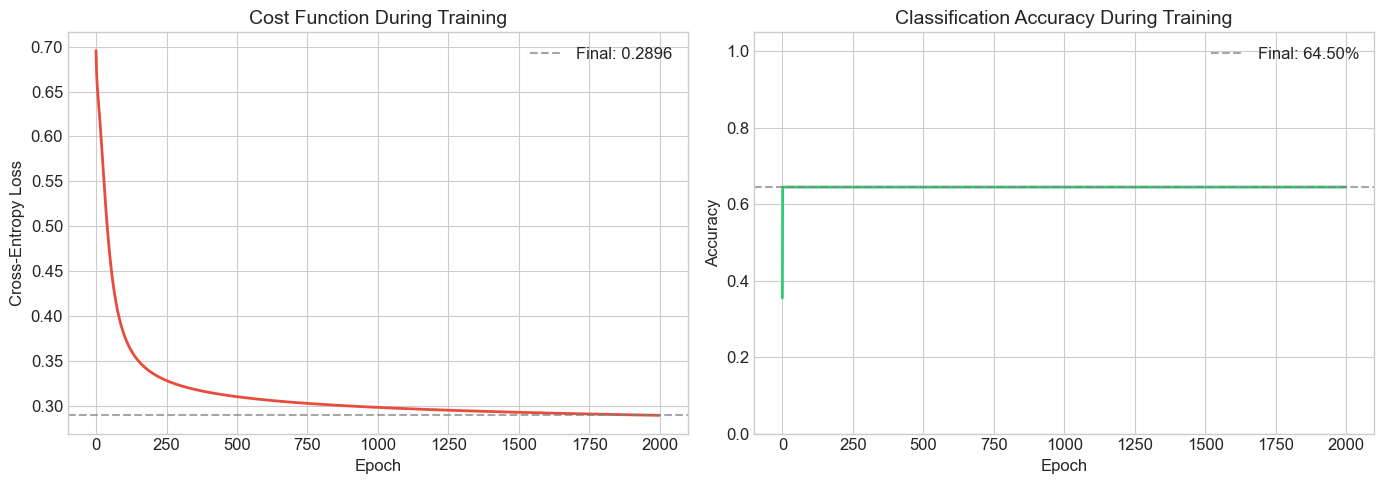

In [21]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Cost over time
ax1 = axes[0]
ax1.plot(history['cost'], linewidth=2, color='#e74c3c')
ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('Cross-Entropy Loss', fontsize=12)
ax1.set_title('Cost Function During Training', fontsize=14)
ax1.axhline(y=history['cost'][-1], color='gray', linestyle='--', alpha=0.7, 
            label=f'Final: {history["cost"][-1]:.4f}')
ax1.legend()

# Plot 2: Accuracy over time
ax2 = axes[1]
ax2.plot(history['accuracy'], linewidth=2, color='#2ecc71')
ax2.set_xlabel('Epoch', fontsize=12)
ax2.set_ylabel('Accuracy', fontsize=12)
ax2.set_title('Classification Accuracy During Training', fontsize=14)
ax2.axhline(y=history['accuracy'][-1], color='gray', linestyle='--', alpha=0.7,
            label=f'Final: {history["accuracy"][-1]:.2%}')
ax2.set_ylim(0, 1.05)
ax2.legend()

plt.tight_layout()
plt.show()

## 10. Visualizing Predictions in 3D

In [22]:
# Get final predictions
h_final, _ = forward(X, W1_trained, W2_trained)
predictions = (h_final >= 0.5).astype(float)
correct = (predictions == y).flatten()

# Create interactive 3D scatter plot showing predictions
fig = go.Figure()

# Correct predictions - Class 0
mask_correct_0 = correct & (y.flatten() == 0)
fig.add_trace(go.Scatter3d(
    x=X_raw[mask_correct_0, 0],
    y=X_raw[mask_correct_0, 1],
    z=X_raw[mask_correct_0, 2],
    mode='markers',
    marker=dict(size=6, color='#3498db', opacity=0.7, symbol='circle'),
    name='Class 0 (Correct)'
))

# Correct predictions - Class 1
mask_correct_1 = correct & (y.flatten() == 1)
fig.add_trace(go.Scatter3d(
    x=X_raw[mask_correct_1, 0],
    y=X_raw[mask_correct_1, 1],
    z=X_raw[mask_correct_1, 2],
    mode='markers',
    marker=dict(size=6, color='#e74c3c', opacity=0.7, symbol='circle'),
    name='Class 1 (Correct)'
))

# Incorrect predictions
mask_incorrect = ~correct
if np.any(mask_incorrect):
    fig.add_trace(go.Scatter3d(
        x=X_raw[mask_incorrect, 0],
        y=X_raw[mask_incorrect, 1],
        z=X_raw[mask_incorrect, 2],
        mode='markers',
        marker=dict(size=10, color='yellow', opacity=1.0, symbol='x',
                   line=dict(color='black', width=2)),
        name='Misclassified'
    ))

fig.update_layout(
    title=f'Neural Network Classification Results (Accuracy: {np.mean(correct):.1%})',
    scene=dict(
        xaxis_title='x₁',
        yaxis_title='x₂',
        zaxis_title='x₃'
    ),
    width=800,
    height=600,
    legend=dict(x=0.7, y=0.9)
)

fig.show()

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

## 11. Visualizing the Decision Boundary

Unlike logistic regression (which has a flat plane as decision boundary), the neural network can create **curved** decision boundaries!

In [23]:
# Create a grid in 3D space to visualize the decision boundary
# We'll show a slice where we vary x1 and x2, and plot probability as color

fig = go.Figure()

# Add data points colored by predicted probability
fig.add_trace(go.Scatter3d(
    x=X_raw[:, 0],
    y=X_raw[:, 1],
    z=X_raw[:, 2],
    mode='markers',
    marker=dict(
        size=6,
        color=h_final.flatten(),
        colorscale='RdBu_r',
        opacity=0.8,
        colorbar=dict(title='P(Class=1)'),
        cmin=0,
        cmax=1
    ),
    name='Data points'
))

fig.update_layout(
    title='Neural Network Predictions (Color = Probability)',
    scene=dict(
        xaxis_title='x₁',
        yaxis_title='x₂',
        zaxis_title='x₃'
    ),
    width=800,
    height=600
)

fig.show()

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

## 12. Visualizing the Neural Network

Let's create a visual representation of our trained neural network.

<>:30: SyntaxWarning:

invalid escape sequence '\s'

<>:36: SyntaxWarning:

invalid escape sequence '\s'

<>:56: SyntaxWarning:

invalid escape sequence '\m'

<>:58: SyntaxWarning:

invalid escape sequence '\m'

<>:62: SyntaxWarning:

invalid escape sequence '\m'

<>:30: SyntaxWarning:

invalid escape sequence '\s'

<>:36: SyntaxWarning:

invalid escape sequence '\s'

<>:56: SyntaxWarning:

invalid escape sequence '\m'

<>:58: SyntaxWarning:

invalid escape sequence '\m'

<>:62: SyntaxWarning:

invalid escape sequence '\m'

C:\Users\leoje\AppData\Local\Temp\ipykernel_38860\2771477153.py:30: SyntaxWarning:

invalid escape sequence '\s'

C:\Users\leoje\AppData\Local\Temp\ipykernel_38860\2771477153.py:36: SyntaxWarning:

invalid escape sequence '\s'

C:\Users\leoje\AppData\Local\Temp\ipykernel_38860\2771477153.py:56: SyntaxWarning:

invalid escape sequence '\m'

C:\Users\leoje\AppData\Local\Temp\ipykernel_38860\2771477153.py:58: SyntaxWarning:

invalid escape sequence '\m'

C:\Users\leoje

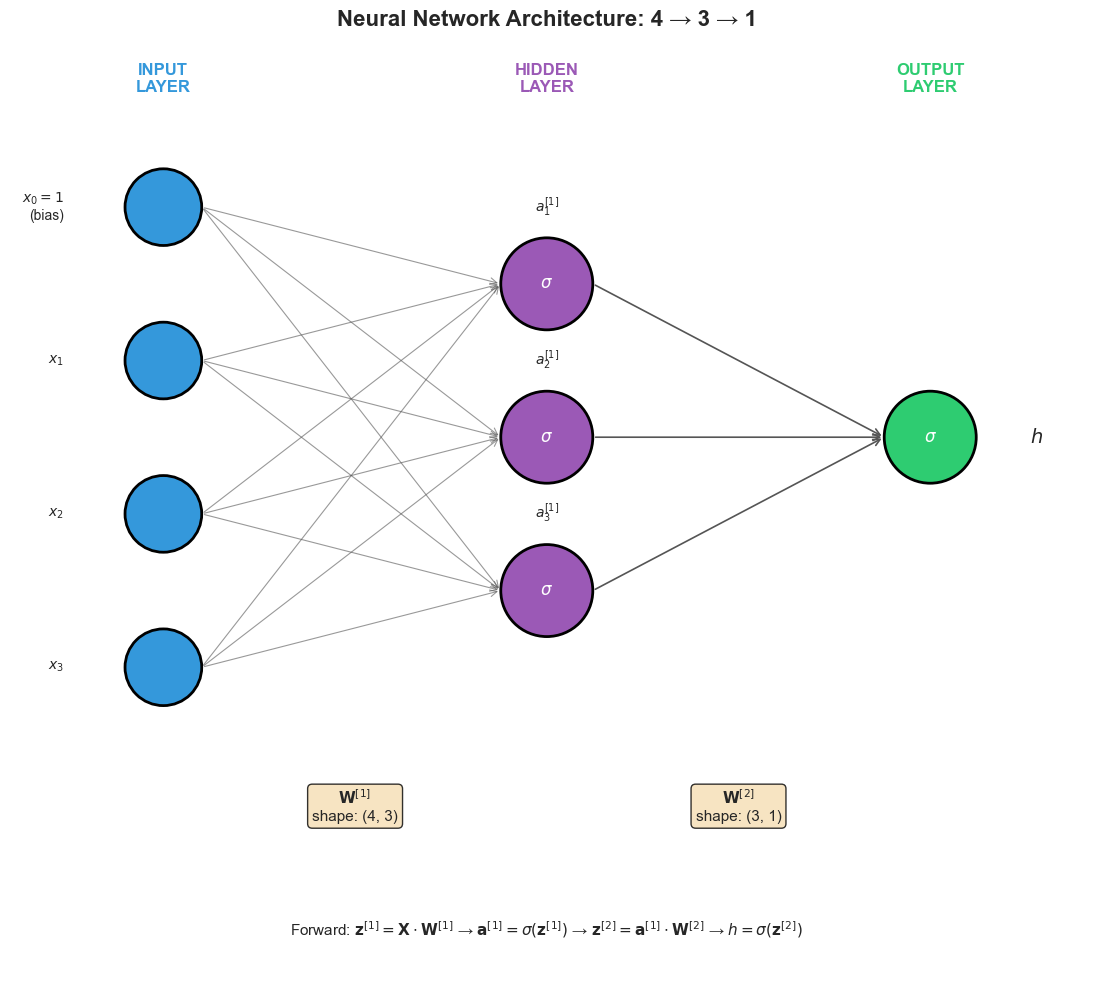

In [24]:
# Create a proper neural network diagram using matplotlib
fig, ax = plt.subplots(figsize=(14, 10))
ax.set_xlim(-1, 13)
ax.set_ylim(-2, 10)
ax.set_aspect('equal')
ax.axis('off')

# Positions
input_x = 1
hidden_x = 6
output_x = 11

input_ys = [8, 6, 4, 2]
hidden_ys = [7, 5, 3]
output_ys = [5]

input_labels = ['$x_0 = 1$\n(bias)', '$x_1$', '$x_2$', '$x_3$']
hidden_labels = ['$a_1^{[1]}$', '$a_2^{[1]}$', '$a_3^{[1]}$']

# Draw input nodes
for i, (iy, label) in enumerate(zip(input_ys, input_labels)):
    circle = plt.Circle((input_x, iy), 0.5, color='#3498db', ec='black', linewidth=2, zorder=3)
    ax.add_patch(circle)
    ax.text(input_x - 1.3, iy, label, fontsize=10, ha='right', va='center')

# Draw hidden nodes
for i, (hy, label) in enumerate(zip(hidden_ys, hidden_labels)):
    circle = plt.Circle((hidden_x, hy), 0.6, color='#9b59b6', ec='black', linewidth=2, zorder=3)
    ax.add_patch(circle)
    ax.text(hidden_x, hy, '$\sigma$', fontsize=12, ha='center', va='center', color='white', fontweight='bold')
    ax.text(hidden_x, hy + 1, label, fontsize=10, ha='center', va='center')

# Draw output node
circle = plt.Circle((output_x, output_ys[0]), 0.6, color='#2ecc71', ec='black', linewidth=2, zorder=3)
ax.add_patch(circle)
ax.text(output_x, output_ys[0], '$\sigma$', fontsize=12, ha='center', va='center', color='white', fontweight='bold')
ax.text(output_x + 1.3, output_ys[0], '$h$', fontsize=14, ha='left', va='center', fontweight='bold')

# Draw connections: input to hidden (W1)
for i, iy in enumerate(input_ys):
    for j, hy in enumerate(hidden_ys):
        ax.annotate('', xy=(hidden_x - 0.6, hy), xytext=(input_x + 0.5, iy),
                   arrowprops=dict(arrowstyle='->', color='#555', lw=0.8, alpha=0.6))

# Draw connections: hidden to output (W2)
for i, hy in enumerate(hidden_ys):
    ax.annotate('', xy=(output_x - 0.6, output_ys[0]), xytext=(hidden_x + 0.6, hy),
               arrowprops=dict(arrowstyle='->', color='#555', lw=1.2))

# Add layer labels
ax.text(input_x, 9.5, 'INPUT\nLAYER', fontsize=12, ha='center', fontweight='bold', color='#3498db')
ax.text(hidden_x, 9.5, 'HIDDEN\nLAYER', fontsize=12, ha='center', fontweight='bold', color='#9b59b6')
ax.text(output_x, 9.5, 'OUTPUT\nLAYER', fontsize=12, ha='center', fontweight='bold', color='#2ecc71')

# Add weight matrix annotations
ax.text(3.5, 0, '$\mathbf{W}^{[1]}$\nshape: (4, 3)', fontsize=11, ha='center', 
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
ax.text(8.5, 0, '$\mathbf{W}^{[2]}$\nshape: (3, 1)', fontsize=11, ha='center',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

# Add equations at bottom
ax.text(6, -1.5, 'Forward: $\mathbf{z}^{[1]} = \mathbf{X} \cdot \mathbf{W}^{[1]}$ → $\mathbf{a}^{[1]} = \sigma(\mathbf{z}^{[1]})$ → $\mathbf{z}^{[2]} = \mathbf{a}^{[1]} \cdot \mathbf{W}^{[2]}$ → $h = \sigma(\mathbf{z}^{[2]})$', 
        fontsize=11, ha='center')

plt.title('Neural Network Architecture: 4 → 3 → 1', fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

## 13. What the Hidden Layer Learned

Let's look at what features the hidden layer has learned.

In [25]:
# Visualize the hidden layer activations
_, cache_final = forward(X, W1_trained, W2_trained)
a1_final = cache_final['a1']

# Create a 3D plot of hidden activations colored by true class
fig = go.Figure()

# Class 0
mask_0 = y.flatten() == 0
fig.add_trace(go.Scatter3d(
    x=a1_final[mask_0, 0],
    y=a1_final[mask_0, 1],
    z=a1_final[mask_0, 2],
    mode='markers',
    marker=dict(size=6, color='#3498db', opacity=0.7),
    name='Class 0'
))

# Class 1
mask_1 = y.flatten() == 1
fig.add_trace(go.Scatter3d(
    x=a1_final[mask_1, 0],
    y=a1_final[mask_1, 1],
    z=a1_final[mask_1, 2],
    mode='markers',
    marker=dict(size=6, color='#e74c3c', opacity=0.7),
    name='Class 1'
))

fig.update_layout(
    title='Hidden Layer Activations (Learned Features)',
    scene=dict(
        xaxis_title='a₁⁽¹⁾ (Hidden Neuron 1)',
        yaxis_title='a₂⁽¹⁾ (Hidden Neuron 2)',
        zaxis_title='a₃⁽¹⁾ (Hidden Neuron 3)'
    ),
    width=800,
    height=600
)

fig.show()

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

**Key Insight:** The hidden layer transforms the data into a new space where the classes are more **linearly separable**. The output layer then just needs to draw a single hyperplane in this transformed space!

## 14. Comparison: Logistic Regression vs Neural Network

Let's compare our neural network with the logistic regression from L3.

In [26]:
# Train logistic regression for comparison
def train_logistic_regression(X, y, lr=0.5, epochs=1000):
    """Train logistic regression (single neuron)."""
    np.random.seed(42)
    W = np.random.randn(X.shape[1], 1) * 0.01
    
    costs = []
    for _ in range(epochs):
        h = 1 / (1 + np.exp(-np.dot(X, W)))
        cost = -np.mean(y * np.log(h + 1e-15) + (1 - y) * np.log(1 - h + 1e-15))
        costs.append(cost)
        dW = np.dot(X.T, (h - y)) / len(y)
        W = W - lr * dW
    
    h_final = 1 / (1 + np.exp(-np.dot(X, W)))
    accuracy = np.mean((h_final >= 0.5) == y)
    
    return W, costs, accuracy

# Train both models
W_logreg, costs_logreg, acc_logreg = train_logistic_regression(X, y)

print("="*60)
print("MODEL COMPARISON")
print("="*60)
print(f"\nLogistic Regression (Single Neuron):")
print(f"  Parameters: {W_logreg.shape[0]}")
print(f"  Final Cost: {costs_logreg[-1]:.4f}")
print(f"  Accuracy:   {acc_logreg:.2%}")

print(f"\nNeural Network (4 → 3 → 1):")
print(f"  Parameters: {W1_trained.size + W2_trained.size}")
print(f"  Final Cost: {history['cost'][-1]:.4f}")
print(f"  Accuracy:   {history['accuracy'][-1]:.2%}")

print("\n" + "="*60)
improvement = history['accuracy'][-1] - acc_logreg
if improvement > 0:
    print(f"Neural network improved accuracy by {improvement:.2%}!")
else:
    print(f"Both models achieve similar performance on this dataset.")

MODEL COMPARISON

Logistic Regression (Single Neuron):
  Parameters: 4
  Final Cost: 0.0947
  Accuracy:   97.00%

Neural Network (4 → 3 → 1):
  Parameters: 15
  Final Cost: 0.2896
  Accuracy:   64.50%

Both models achieve similar performance on this dataset.


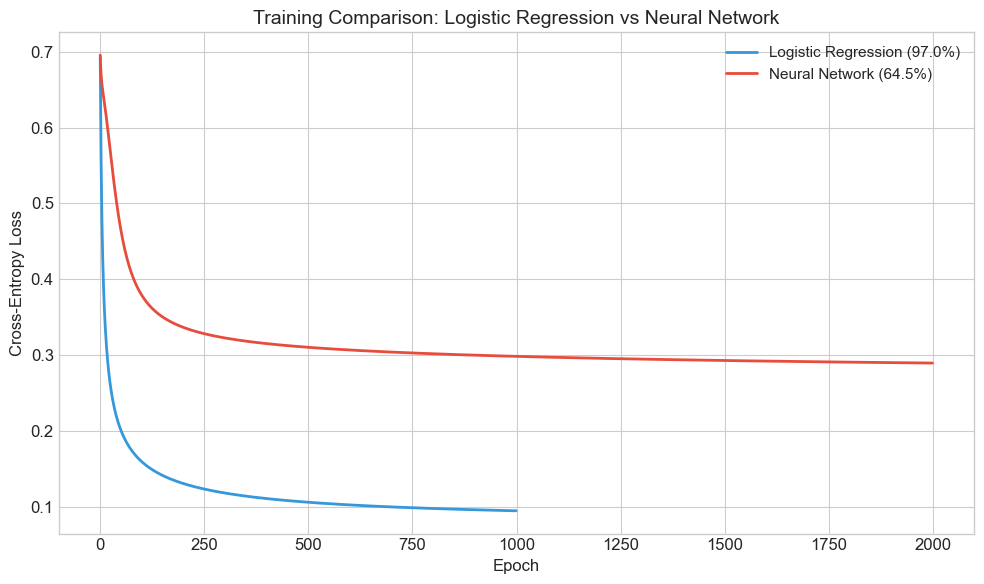

In [27]:
# Plot comparison
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(costs_logreg, linewidth=2, color='#3498db', label=f'Logistic Regression ({acc_logreg:.1%})')
ax.plot(history['cost'], linewidth=2, color='#e74c3c', label=f'Neural Network ({history["accuracy"][-1]:.1%})')

ax.set_xlabel('Epoch', fontsize=12)
ax.set_ylabel('Cross-Entropy Loss', fontsize=12)
ax.set_title('Training Comparison: Logistic Regression vs Neural Network', fontsize=14)
ax.legend(fontsize=11)

plt.tight_layout()
plt.show()

## 15. Experimenting with Hidden Layer Size

Let's see how the number of hidden neurons affects performance.

In [28]:
# Experiment with different hidden layer sizes
hidden_sizes = [1, 2, 3, 5, 10, 20]
results = []

print("Experimenting with different hidden layer sizes...")
print("="*50)

for n_hidden in hidden_sizes:
    W1, W2, hist = train(
        X, y, 
        n_hidden=n_hidden, 
        lr=1.0, 
        epochs=2000,
        print_every=10000  # Suppress output
    )
    results.append({
        'n_hidden': n_hidden,
        'params': W1.size + W2.size,
        'accuracy': hist['accuracy'][-1],
        'cost': hist['cost'][-1]
    })
    print(f"Hidden neurons: {n_hidden:2d} | Params: {W1.size + W2.size:3d} | Accuracy: {hist['accuracy'][-1]:.2%}")

print("="*50)

Experimenting with different hidden layer sizes...
Training neural network...
Architecture: 4 → 1 → 1
Learning rate: 1.0, Epochs: 2000
Epoch    0: Cost = 0.6933, Accuracy = 35.50%
Final: Cost = 0.2839, Accuracy = 64.50%
Hidden neurons:  1 | Params:   5 | Accuracy: 64.50%
Training neural network...
Architecture: 4 → 2 → 1
Learning rate: 1.0, Epochs: 2000
Epoch    0: Cost = 0.6931, Accuracy = 64.50%
Final: Cost = 0.2881, Accuracy = 64.50%
Hidden neurons:  2 | Params:  10 | Accuracy: 64.50%
Training neural network...
Architecture: 4 → 3 → 1
Learning rate: 1.0, Epochs: 2000
Epoch    0: Cost = 0.6956, Accuracy = 35.50%
Final: Cost = 0.2896, Accuracy = 64.50%
Hidden neurons:  3 | Params:  15 | Accuracy: 64.50%
Training neural network...
Architecture: 4 → 5 → 1
Learning rate: 1.0, Epochs: 2000
Epoch    0: Cost = 0.6936, Accuracy = 35.50%
Final: Cost = 0.0677, Accuracy = 97.50%
Hidden neurons:  5 | Params:  25 | Accuracy: 97.50%
Training neural network...
Architecture: 4 → 10 → 1
Learning rate

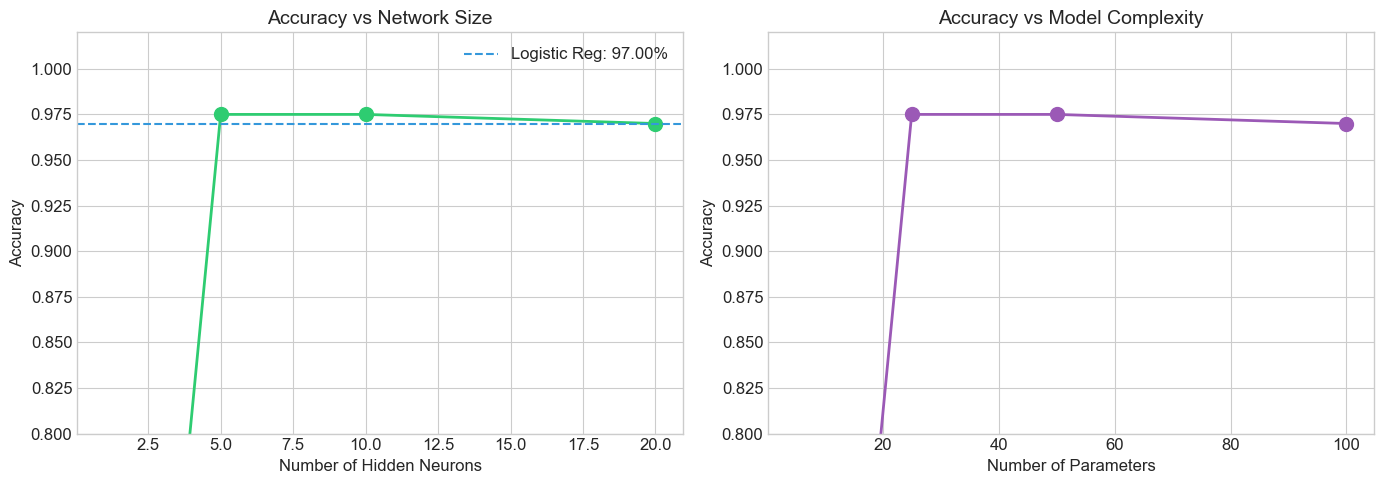

In [29]:
# Plot results
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Accuracy vs hidden neurons
ax1 = axes[0]
ax1.plot([r['n_hidden'] for r in results], [r['accuracy'] for r in results], 
         'o-', linewidth=2, markersize=10, color='#2ecc71')
ax1.axhline(y=acc_logreg, color='#3498db', linestyle='--', label=f'Logistic Reg: {acc_logreg:.2%}')
ax1.set_xlabel('Number of Hidden Neurons', fontsize=12)
ax1.set_ylabel('Accuracy', fontsize=12)
ax1.set_title('Accuracy vs Network Size', fontsize=14)
ax1.legend()
ax1.set_ylim(0.8, 1.02)

# Parameters vs accuracy
ax2 = axes[1]
ax2.plot([r['params'] for r in results], [r['accuracy'] for r in results], 
         'o-', linewidth=2, markersize=10, color='#9b59b6')
ax2.set_xlabel('Number of Parameters', fontsize=12)
ax2.set_ylabel('Accuracy', fontsize=12)
ax2.set_title('Accuracy vs Model Complexity', fontsize=14)
ax2.set_ylim(0.8, 1.02)

plt.tight_layout()
plt.show()

## 16. Summary

### What We Built

A 2-layer neural network from scratch:
- **Forward propagation**: Pass data through layers (linear → activation → linear → activation)
- **Backpropagation**: Compute gradients using chain rule
- **Gradient descent**: Update weights to minimize loss

### Key Formulas

| Step | Formula | Shape |
|------|---------|-------|
| Forward L1 | $\mathbf{z}^{[1]} = \mathbf{X} \cdot \mathbf{W}^{[1]}$ | $(m, n^{[1]})$ |
| Activation L1 | $\mathbf{a}^{[1]} = \sigma(\mathbf{z}^{[1]})$ | $(m, n^{[1]})$ |
| Forward L2 | $\mathbf{z}^{[2]} = \mathbf{a}^{[1]} \cdot \mathbf{W}^{[2]}$ | $(m, n^{[2]})$ |
| Activation L2 | $h = \sigma(\mathbf{z}^{[2]})$ | $(m, n^{[2]})$ |
| Error L2 | $\delta^{[2]} = h - y$ | $(m, n^{[2]})$ |
| Gradient W2 | $\nabla_{\mathbf{W}^{[2]}}J = \frac{1}{m}(\mathbf{a}^{[1]})^T \delta^{[2]}$ | $(n^{[1]}, n^{[2]})$ |
| Error L1 | $\delta^{[1]} = (\delta^{[2]} (\mathbf{W}^{[2]})^T) \odot \sigma'(\mathbf{z}^{[1]})$ | $(m, n^{[1]})$ |
| Gradient W1 | $\nabla_{\mathbf{W}^{[1]}}J = \frac{1}{m}\mathbf{X}^T \delta^{[1]}$ | $(n^{[0]}, n^{[1]})$ |

### What's Next (L5)

- Deeper networks (more layers)
- Different activation functions (ReLU, tanh)
- Multi-class classification (softmax)
- Common problems: vanishing gradients

In [30]:
# Final summary
print("="*60)
print("TRAINING SUMMARY")
print("="*60)
print(f"Dataset size:      {m} samples")
print(f"Architecture:      4 → 3 → 1")
print(f"Total parameters:  {W1_trained.size + W2_trained.size}")
print(f"Learning rate:     1.0")
print(f"Epochs:            2000")
print(f"Final cost:        {history['cost'][-1]:.4f}")
print(f"Final accuracy:    {history['accuracy'][-1]:.2%}")
print("="*60)
print(f"\nComparison with Logistic Regression:")
print(f"  Logistic Reg accuracy:  {acc_logreg:.2%}")
print(f"  Neural Network accuracy: {history['accuracy'][-1]:.2%}")
print("="*60)

TRAINING SUMMARY
Dataset size:      200 samples
Architecture:      4 → 3 → 1
Total parameters:  15
Learning rate:     1.0
Epochs:            2000
Final cost:        0.2896
Final accuracy:    64.50%

Comparison with Logistic Regression:
  Logistic Reg accuracy:  97.00%
  Neural Network accuracy: 64.50%
